

# Project: Investigate a Dataset - TMDB_5000_movies

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 


#### This project explores a robust dataset containing information on movies released from the early 1900s through the late 2010s. The dataset includes 1 table of 5000 unique movies. Key features include: the movie title, id, genre, release date, production company and country of origin, budget, revenue, vote metrics, an overview, popularity, and other types of metadata. The scope of this project with focus on the budget and revenue of these movies.

##### columns: id, title, genres, release_date, production_companies, production_countries, budget, revenue, vote_average, vote_count, overview, popularity, original_language, original title, spoken_languages


### Question(s) for Analysis


#### 1. What are the top grossing movies?

#### 2. Do movies with high revenue have high budgets compared to the rest of movies produced on average?

#### 3. What is the distribution of budgets in our dataset? Are there any outliers?


#### 4. How have movie budgets changed over time?


In [128]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# While optional for current notebooks, if you are having trouble with visualizations,
#   remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html


<a id='wrangling'></a>
## Data Wrangling


### General Properties


In [116]:
# Load your data and print out a few lines. What is the size of your dataframe? 
#   Perform operations to inspect data types and look for instances of missing
#   or possibly errant data. There are at least 4 - 6 methods you can call on your
#   dataframe to obtain this information.

df = pd.read_csv('C:\\Users\\britt\\OneDrive\\Documents\\data\\WGU D496 project\\tmdb_5000_movies.csv')
df.head()

df.info()

df.isnull().sum()

df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000



### Data Cleaning


In [117]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.

#Check for duplicates and drop them if necessary
df.duplicated().sum()

df.drop_duplicates(inplace=True)

In [118]:
#Check for null values and drop them if necessary
df.isnull().sum()

#drop record without release date as it can't be used with our analysis over time
df.dropna(subset=['release_date'], inplace=True)

#convert release_date to datetime format, include only the year for granularity simplicity
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
#extract year from release_date
df['release_year'] = df['release_date'].dt.year
#drop release_date column as it is no longer needed
df.drop(columns=['release_date'], inplace=True)


In [119]:
#adjust budget column to be in millions for easier readability
df['budget'] = df['budget'] / 1000000
#adjust revenue column to be in millions for easier readability
df['revenue'] = df['revenue'] / 1000000

#rename columns to reflect changes
df.rename(columns={'budget': 'budget_millions', 'revenue': 'revenue_millions'}, inplace=True)

#### Duplicates were removed to avoid double counting any movies. The record without a release date was removed due to the inability to use this record for our over time analysis. Budget and revenue were scaled to millions and the column name adjusted to reflect the order of magnitude and improve readability. This allows for more clear interpretation of the data and makes it more user friendly.

In [120]:
## Create function for use in analysis section
# to get top N movies 
def get_top_movies(df, metric='revenue_millions', top_n=25, columns=None):
    #returns top 25 movies with the highest revenue
        #can modify parameters to get more or less movies or based on a different metric like budget
      
    # Parameters:
    # df : dataframe of imported dataset
    # metric (str): Column name to sort by
    # top_n (int): specify number of entries to return
    # columns (list): which columns to include in the output.
    
    # Returns:
    # DataFrame: Sorted DataFrame with top N entries by metric.
    
    
    if columns is None:
        columns = ['title', metric, 'release_year']
    top_movies = df.sort_values(by=metric, ascending=False)
    return top_movies[columns].head(top_n)


<a id='eda'></a>
## Exploratory Data Analysis

### What are the top grossing movies?


In [121]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.

# Use functionto get top grossing movies (based on revenue)
top_grossing = get_top_movies(df, metric='revenue_millions', top_n=25, columns=['title', 'revenue_millions', 'budget_millions', 'release_year'])
top_grossing

,title,revenue_millions,budget_millions,release_year
0,Avatar,2787.965087,237.0,2009
25,Titanic,1845.034188,200.0,1997
16,The Avengers,1519.557910,220.0,2012
28,Jurassic World,1513.528810,150.0,2015
44,Furious 7,1506.249360,190.0,2015
7,Avengers: Age of Ultron,1405.403694,280.0,2015
124,Frozen,1274.219009,150.0,2013
31,Iron Man 3,1215.439994,200.0,2013
546,Minions,1156.730962,74.0,2015
26,Captain America: Civil War,1153.304495,250.0,2016


##### There is a substantial gap between the top grossing movie of this data set and runner up. Avatar took the top spot with a released in 2009 and a revenue of 2.8 billion. Titanic was #2 with 1.8 billion in revenue. The remaining top 10 were closer in revenue than the top 2 spots. Most of the top grossing movies were released since 2009. The notable exception being Titanic which was released in 1997.

### Do movies with high revenue have high budgets compared to the rest of movies produced on average?

In [122]:
#display the top 25 grossing movies budgets
top_grossing[['title', 'budget_millions', 'revenue_millions','release_year']].head(25)
#average budget of the top 25 grossing movies?
top_budget_avg = top_grossing[['budget_millions']].head(25).mean()

#average budget of all movies
all_budget_avg = df[['budget_millions']].mean()

#compare the two averages
print(f"Average budget of top 25 grossing movies: {top_budget_avg}")
print(f"Average budget of all movies: {all_budget_avg}")
print(f'Do top grossing movie budgets tend to be higher than the overall average? {top_budget_avg > all_budget_avg}')


Average budget of top 25 grossing movies: budget_millions    199.64
dtype: float64
Average budget of all movies: budget_millions    29.051088
dtype: float64
Do top grossing movie budgets tend to be higher than the overall average? budget_millions    True
dtype: bool


#### Surprisingly, the overall average budget for movies produced and counted in this dataset was almost substantially lower per movie more than the 25 top grossing movies. This indicates that budget is a significant indicator of success. But are there any outliers in our data?

### What is the distribution of budgets in our dataset? Are there any outliers?

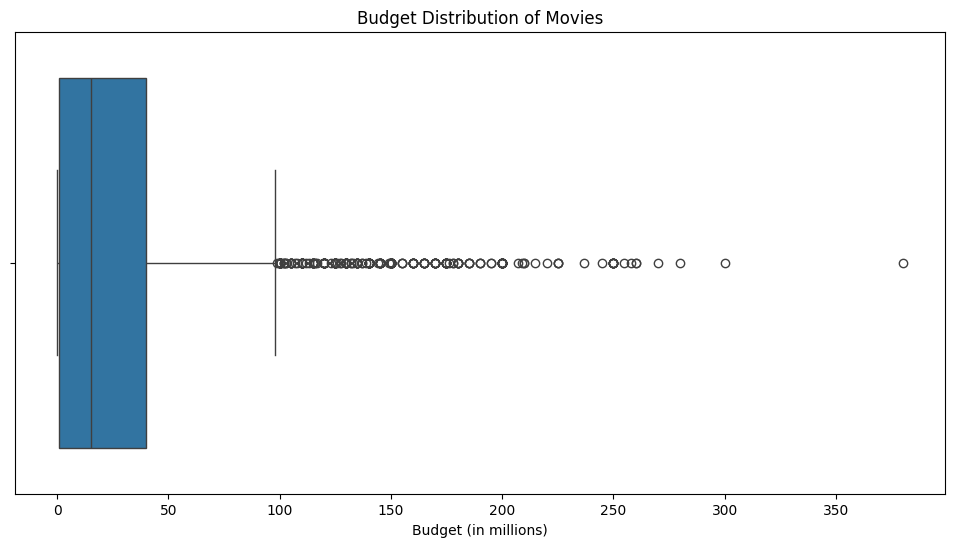

In [ ]:

# budget distribution -- boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='budget_millions')
plt.title('Budget Distribution of Movies')

#rename budgets to millions for better readability on boxplot
plt.xlabel('Budget (in millions)')
plt.show()

In [124]:
# count how many movies have a budget above the boxplot's upper whisker
outliers = df[df['budget_millions'] > df['budget_millions'].quantile(0.75) + 1.5 * (df['budget_millions'].quantile(0.75) - df['budget_millions'].quantile(0.25))]
outlier_count = outliers.shape[0]

#sort outliers by budget
outliers = outliers.sort_values(by='budget_millions', ascending=False).head(25)

#display the number of outliers and their titles and budgets
print(f"Number of movies with budget above the upper whisker: {outlier_count}")
print("Outliers:")
for index, row in outliers.iterrows():
    print(f"Title: {row['title']}, Budget: {row['budget_millions']} million")

# Find overlap between top grossing movies and outliers
overlap = pd.merge(top_grossing[['title', 'budget_millions']], outliers[['title', 'budget_millions']], on='title', how='inner')
print(f"Number of top grossing movies that are also outliers: {overlap.shape[0]}")

Number of movies with budget above the upper whisker: 321
Outliers:
Title: Pirates of the Caribbean: On Stranger Tides, Budget: 380.0 million
Title: Pirates of the Caribbean: At World's End, Budget: 300.0 million
Title: Avengers: Age of Ultron, Budget: 280.0 million
Title: Superman Returns, Budget: 270.0 million
Title: John Carter, Budget: 260.0 million
Title: Tangled, Budget: 260.0 million
Title: Spider-Man 3, Budget: 258.0 million
Title: The Lone Ranger, Budget: 255.0 million
Title: The Hobbit: An Unexpected Journey, Budget: 250.0 million
Title: The Hobbit: The Desolation of Smaug, Budget: 250.0 million
Title: Harry Potter and the Half-Blood Prince, Budget: 250.0 million
Title: The Dark Knight Rises, Budget: 250.0 million
Title: Batman v Superman: Dawn of Justice, Budget: 250.0 million
Title: Captain America: Civil War, Budget: 250.0 million
Title: The Hobbit: The Battle of the Five Armies, Budget: 250.0 million
Title: X-Men: Days of Future Past, Budget: 250.0 million
Title: Spectre,

#### From the previous analysis, we can see that there are 321 outliers in our dataset of approximately 5000 movies. Of those, 9 are included in our top 25 grossing movies. While our outliers consist of half a percent of our total movies, they account for over a third of our top grossing set. Further evidence that a higher budget can increase the success of producing a top grossing movie.

### How have movie budgets changed over time?


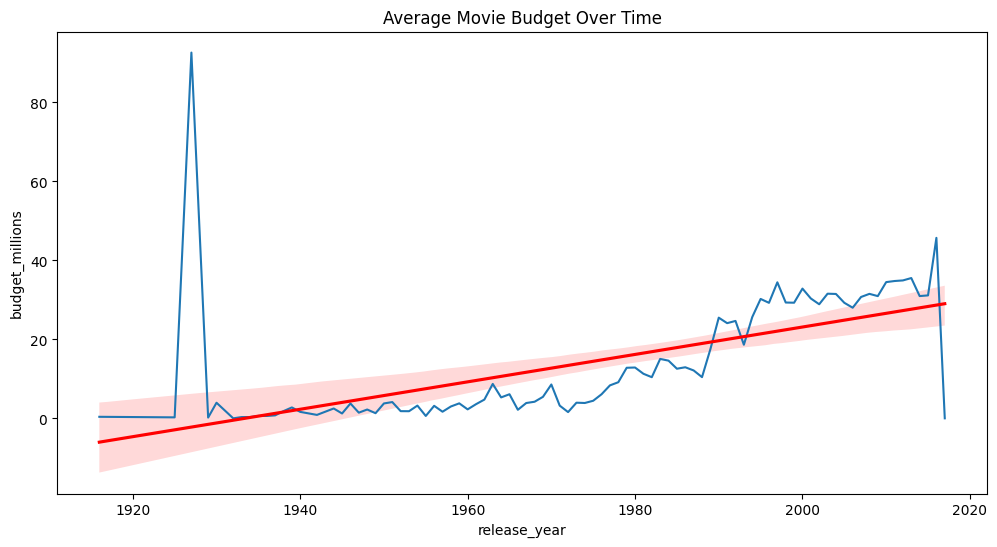

Year with the highest average budget: 1927.0 with an average budget of 92.62 million


In [ ]:
#creat new df to calculate average budget per year
budget_over_time = df.groupby('release_year')['budget_millions'].mean().reset_index()


#create a line plot to visualize the average budget over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=budget_over_time, x='release_year', y='budget_millions')
plt.title('Average Movie Budget Over Time')
plt.xlabel('Release Year')
plt.ylabel('Average Budget (in millions)')

# overlay a trendline
sns.regplot(data=budget_over_time, x='release_year', y='budget_millions', scatter=False, color='red')
plt.show()

#year with the highest average budget
highest_budget_year = budget_over_time.loc[budget_over_time['budget_millions'].idxmax()]
print(f"Year with the highest average budget: {highest_budget_year['release_year']} with an average budget of {highest_budget_year['budget_millions']} million")

#### It is clear to see 1927 stands as a clear outlier in our dataset. If we ignore this year, an obvious trend to our data. Over time the average budget per movie has increased significantly. Given most top grossing movies were released after 1990, there is a strong argument to be made that increased budgets increase the chance of success.

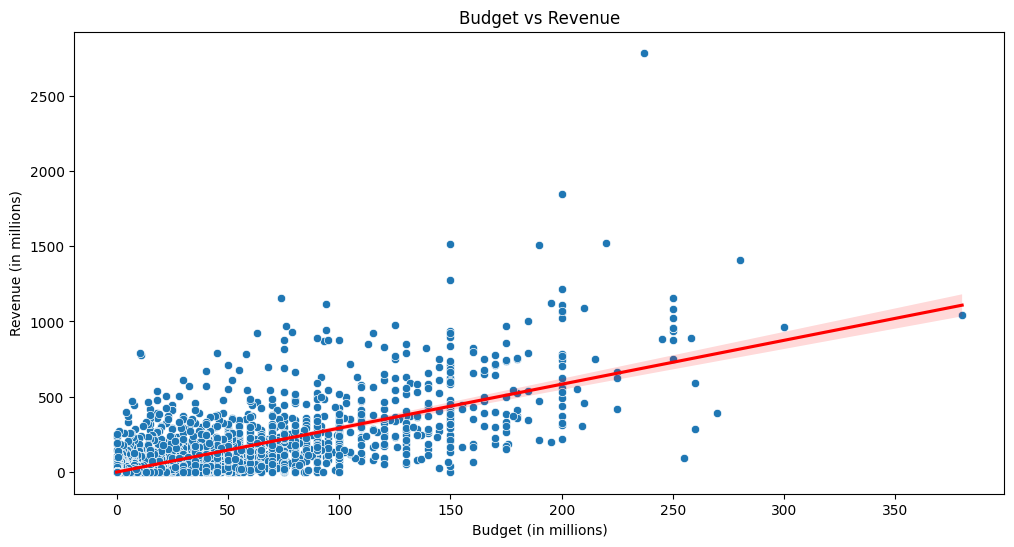

In [ ]:
#create scatter plot to visualize budget vs revenue
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='budget_millions', y='revenue_millions')
#overlay a trendline on the scatter plot
sns.regplot(data=df, x='budget_millions', y='revenue_millions', scatter=False, color='red')


#update labels and title
plt.title('Budget vs Revenue')
plt.xlabel('Budget (in millions)')
plt.ylabel('Revenue (in millions)')
plt.show()


### The scatterplot above helps demonstate the correlation between budget and revenue. It is clear to see that a high budget tends to also mean a higher revenue.

<a id='conclusions'></a>
## Conclusions

### Focusing on the dataset, we began by understanding the data and removing duplicates. I wanted to take a look at top grossing movies and see if there was a connection between budgets and success. At a quick glance, we see a lot of variance in the budgets of the top 25 grossing movies. Even more, the average budget was significantly higher than the overall movie budget average. By creating a box plot, we see many movies lying outside our upper whisker. These outliers make up about .33% of all movies. However, they account for 36% of the top 25 grossing movies. Given the suspected connection between budget and success, I wanted to take a look at how budgets have changed over time. Aside from the outlier of the year 1927, there has been a slow trend of increasing the budget for movies. Around 1990, this trend strengthened. Given all this information, it does not surprise me that all the movies on the top grossing list were released after 1990. This analysis suggests a strong link between higher budgets and higher revenues, but does not mean causal. To further understand what other confounding factors may be at play, taking a look at actor pay over the years may provide valuable insight as to the increasing budgets over time. Perhaps well-known actors are paid significantly higher (after accounting for inflation) than before the 1990s. Furthermore, looking at the changes in special effects over time and the cost to produce them as compared to traditional or low-tech productions may also help us understand the cost in budgets.

## Submitting your Project -- converting the nb


In [127]:
# Running this cell will execute a bash command to convert this notebook to an .html file
!python -m nbconvert --to html Investigate_a_Dataset-TMDB_movies.ipynb

[NbConvertApp] Converting notebook Investigate_a_Dataset-TMDB_movies.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 411470 bytes to Investigate_a_Dataset-TMDB_movies.html
